In [1]:
# https://www.kaggle.com/docs/api Можно по этой доке загружать датасеты, нужно создать ключ и перенести его в нужную деррикторию
# Есть видео с гайд
!pip install kaggle

In [43]:
from kaggle.api.kaggle_api_extended import KaggleApi


from zipfile import ZipFile

import warnings
warnings.filterwarnings("ignore")

In [42]:
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


#Models
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import Pool, CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection, linear_model, preprocessing, ensemble, metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


# Dimensionality Reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#import umap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


import xgboost as xgb
#!pip install mlxtend
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# import itertools
# import matplotlib.gridspec as gridspec

In [8]:
!kaggle competitions download -c ghouls-goblins-and-ghosts-train


  0%|          | 0.00/38.0k [00:00<?, ?B/s]
100%|##########| 38.0k/38.0k [00:00<00:00, 5.57MB/s]


In [44]:
zip_file = ZipFile('ghouls-goblins-and-ghosts-boo.zip')
print('Выводим все файлы , которые есть в zip архиве... ')
print([i.filename for i in zip_file.infolist()])
train = pd.read_csv(zip_file.open('train.csv.zip'), compression='zip')
train

Выводим все файлы , которые есть в zip архиве... 
['sample_submission.csv.zip', 'test.csv.zip', 'train.csv.zip']


,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost
...,...,...,...,...,...,...,...
366,886,0.458132,0.391760,0.660590,0.635689,blue,Goblin
367,889,0.331936,0.564836,0.539216,0.551471,green,Ghost
368,890,0.481640,0.501147,0.496446,0.544003,clear,Ghoul
369,896,0.294943,0.771286,0.583503,0.300618,clear,Ghost


### Goblins , Ghosts and Ghouls!!

#### https://www.kaggle.com/mrtgocer/from-zero-to-hero-lightgbm-classifier
Вот эта интересная визуализация, но тебе стоит посмотреть ещё ноутбуки, мне казалось, там было что-то крутое, но я пока что не нашёл

In [113]:
train = pd.read_csv('/Users/irak/Documents/py_viz/ghosts/ghouls-goblins-and-ghosts-boo/train.csv.zip')

#### Describe dataset:

id - id of the creature

bone_length - average length of bone in the creature, normalized between 0 and 1

rotting_flesh - percentage of rotting flesh in the creature

hair_length - average hair length, normalized between 0 and 1

has_soul - percentage of soul in the creature

color - dominant color of the creature: 'white','black','clear','blue','green','blood'

type - target variable: 'Ghost', 'Goblin', and 'Ghoul'

In [4]:
set(train.type)

{'Ghost', 'Ghoul', 'Goblin'}

In [45]:
display(train.describe())
display(train.describe(include=['object']))


,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


,color,type
count,371,371
unique,6,3
top,white,Ghoul
freq,137,129


In [46]:
# https://stackoverflow.com/questions/30942577/seaborn-correlation-coefficient-on-pairgrid
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    from scipy.stats import pearsonr
    import matplotlib.pyplot as plt 
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

In [47]:
sns.set_palette('tab10')  

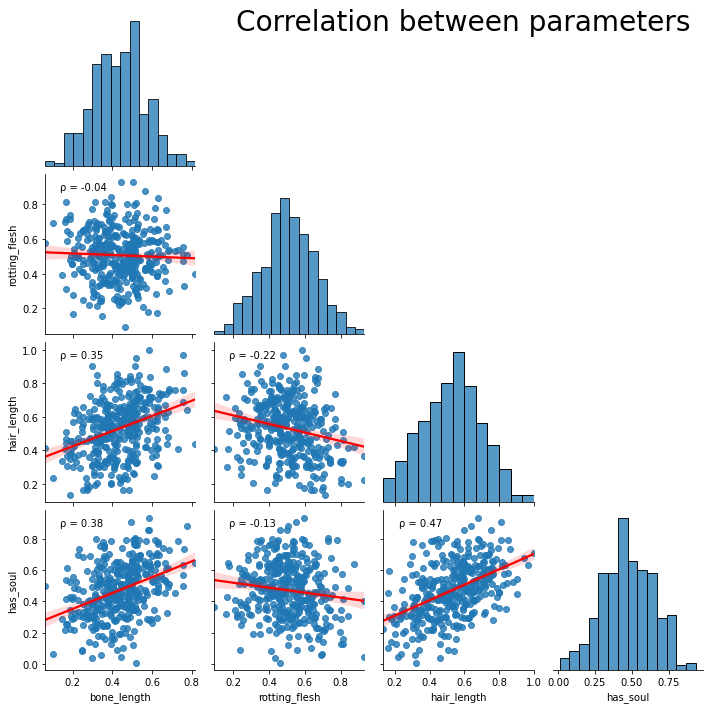

In [48]:
# scatter_matrix(train, alpha=1, s=5, c = 'black', figsize=(6, 6), diagonal="kde");
g = sns.pairplot(train.iloc[:,1:], kind="reg", plot_kws={'line_kws':{'color':'red'}}, corner=True)
g.fig.suptitle("Correlation between parameters", fontsize=28, x=0.65)
g.map_lower(corrfunc)

#### These params have normal distribution. Could viz this, using PCA 

Text(0.65, 0.98, 'Monsters characterisic distributions')

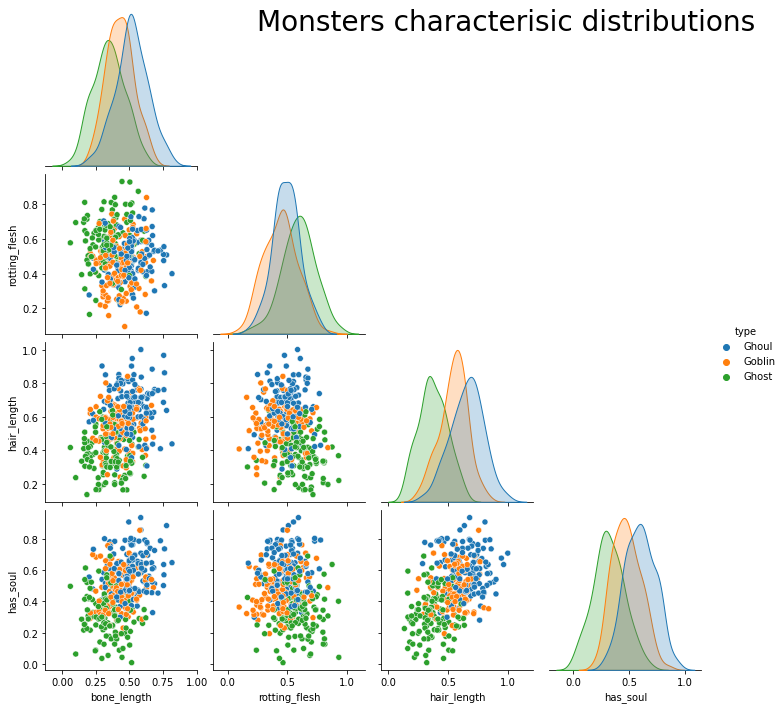

In [49]:
g = sns.pairplot(train.iloc[:,1:], hue="type", corner=True)
g.fig.suptitle("Monsters characterisic distributions", fontsize=28, x=0.65)

### Correlation between params

<AxesSubplot:>

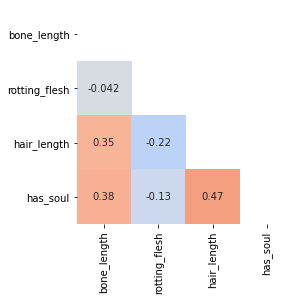

In [50]:
corr = train.iloc[:, 1:-2].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', cbar=False, square=True)

### Correlation by classes

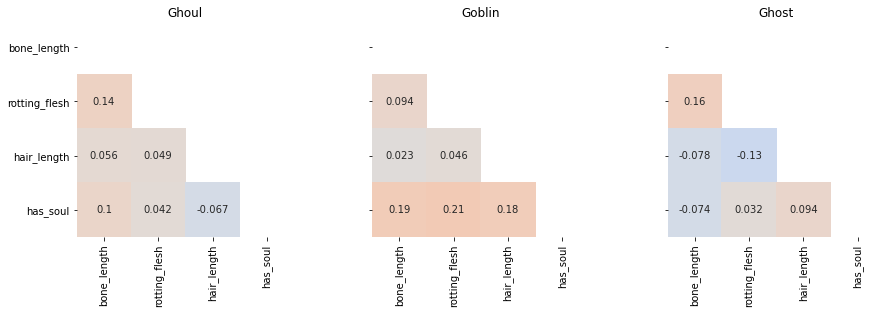

In [51]:
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True, figsize=(15, 4))

monsters=['Ghoul', 'Goblin', 'Ghost']
#for index, item in zip( range(3), monsters): # Лучше использовать zip , когда нужно проходиться по паре признаков,либо enumarate ,если нужен индекс
for index, item in enumerate(monsters):    
    corr = train[train['type']==item].iloc[:, 1:-2].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', cbar=False, square=True, ax=ax[index])
    ax[index].set_title(item, pad = 2)

## Categorical feature - color

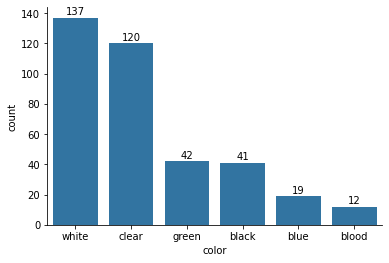

In [52]:
ax = sns.countplot(x="color", data=train, order = train['color'].value_counts().index, color='tab:blue')
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+2), ha='center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

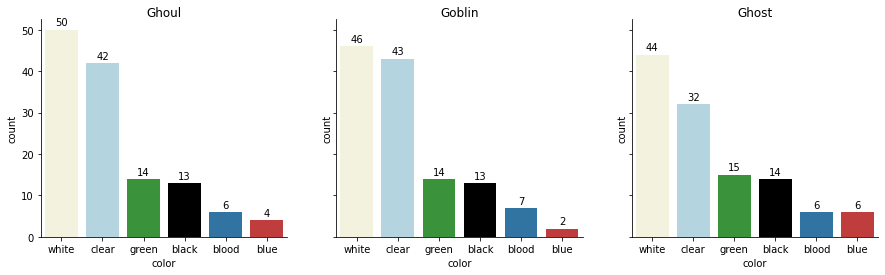

In [53]:
colors = ['beige', 'lightblue', 'tab:green', 'black', 'tab:blue', "tab:red"]
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True, figsize=(15, 4))
n = 0
for c in train['type'].unique():
    sns.countplot(ax=ax[n], x = train[train['type'] == c]['color'], palette=colors, order = train[train['type'] == c]['color'].value_counts().index)
    ax[n].set_title(c, pad = 2) 
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['top'].set_visible(False)
    for p in ax[n].patches:
        ax[n].annotate('{:}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+1), ha='center') 
    n+=1


In [54]:
train['type'].value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

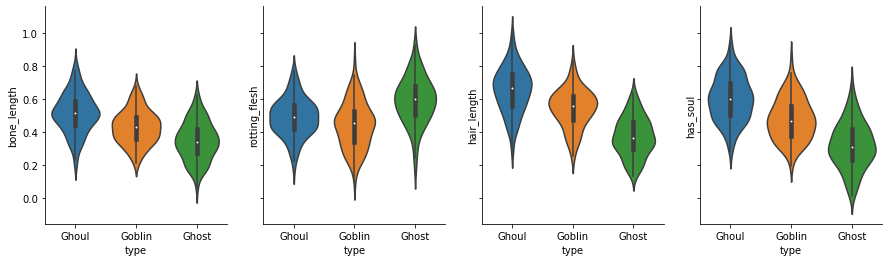

In [55]:
fig, ax = plt.subplots(1, 4, sharex = True, sharey = True, figsize=(15, 4))
n = 0
for c in train.iloc[:, 1:-2].columns:
    sns.violinplot(ax=ax[n], x = train['type'], y=train[c])
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['top'].set_visible(False)
    n+=1
## Честно говоря , я с такими штуками не пробовал работать ,хоть они и круче, чем боксплот

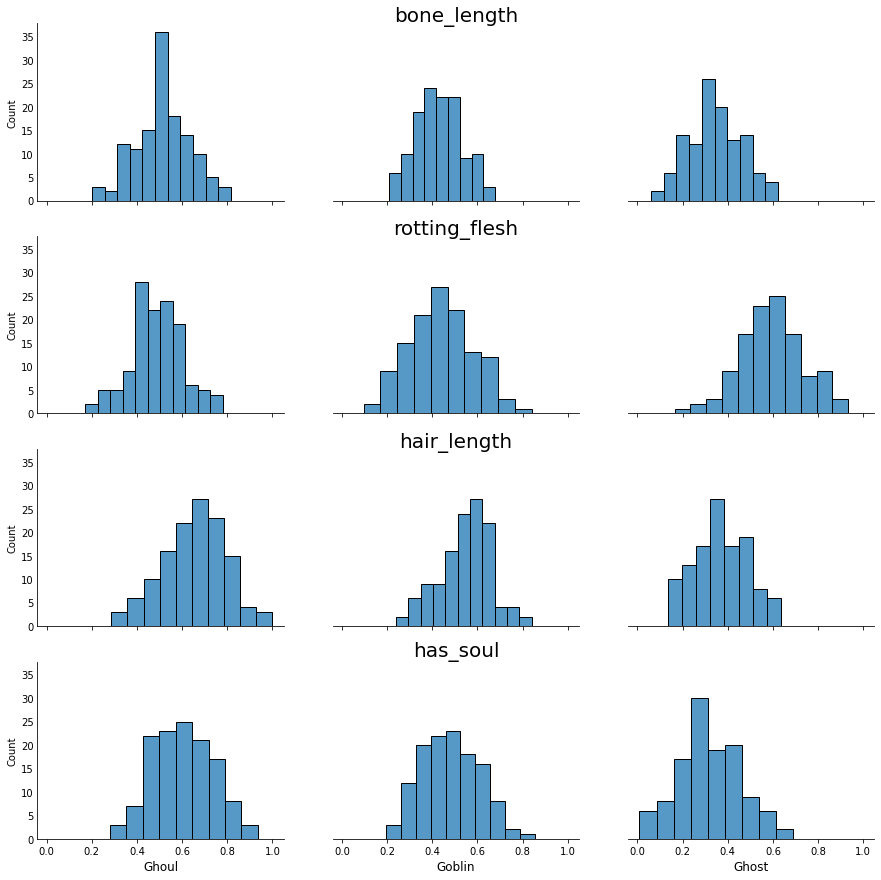

In [57]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize=(15, 15))
ro = 0
co = 0
for t in train['type'].unique():
    for col in train.columns[1:5]:
        sns.histplot(ax=ax[ro, co], x = train[train['type'] == t][col])
        ax[ro, co].spines['right'].set_visible(False)
        ax[ro, co].spines['top'].set_visible(False)
        ax[ro, co].tick_params(axis='y', which=u'both',length=0)
        # ax[ro, co].set_ylabel(col)
        if co == 1:
            ax[ro, co].set_title(col, pad = 2, fontsize=20)
            ax[ro, co].spines['left'].set_visible(False)
        elif co == 2:
            ax[ro, co].spines['left'].set_visible(False)
        ax[ro, co].set_xlabel(t, fontsize=12)
        ro += 1
    co += 1
    ro = 0

Hair distribution has more variability.

## Classification monsters

In [58]:
train[train["type"] == 'Ghost'].iloc[:, 1:5]

,bone_length,rotting_flesh,hair_length,has_soul
4,0.566117,0.875862,0.418594,0.636438
8,0.314295,0.671280,0.417267,0.227548
9,0.280942,0.701457,0.179633,0.141183
16,0.250770,0.246258,0.554654,0.250036
19,0.524080,0.750988,0.524637,0.443358
...,...,...,...,...
354,0.356999,0.671331,0.296784,0.689980
358,0.440432,0.309498,0.203057,0.194105
363,0.507583,0.799623,0.334520,0.344403
367,0.331936,0.564836,0.539216,0.551471


In [59]:
print([i.filename for i in zip_file.infolist()])
train = pd.read_csv(zip_file.open('train.csv.zip'), compression='zip')

test = pd.read_csv(zip_file.open('test.csv.zip'), compression='zip')
sample_submission = pd.read_csv(zip_file.open('sample_submission.csv.zip'), compression='zip')
sample_submission

['sample_submission.csv.zip', 'test.csv.zip', 'train.csv.zip']


,id,type
0,3,Ghost
1,6,Ghost
2,9,Ghost
3,10,Ghost
4,13,Ghost
...,...,...
524,893,Ghost
525,894,Ghost
526,895,Ghost
527,898,Ghost


#### Make functions to convert categorical target   str -> int and vice versa.

In [60]:
def code_target(row):
    if row=='Ghost':
        return 0
    elif row=='Ghoul':
        return 1
    else:
        return 2
    
def reverse_target(row):
    if row==0:
        return 'Ghost'
    elif row==1:
        return 'Ghoul'
    else:
        return 'Goblin'
#train.type=train.type.apply(code_target)
train

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost
...,...,...,...,...,...,...,...
366,886,0.458132,0.391760,0.660590,0.635689,blue,Goblin
367,889,0.331936,0.564836,0.539216,0.551471,green,Ghost
368,890,0.481640,0.501147,0.496446,0.544003,clear,Ghoul
369,896,0.294943,0.771286,0.583503,0.300618,clear,Ghost


In [61]:
y=train.type.apply(code_target)
X=pd.get_dummies(train.iloc[:,1:6])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)


In [62]:
set(y_train)

{0, 1, 2}

### Try to see result with basic KNN model

In [64]:
test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train, y_train)
    
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

In [65]:
## score that comes from testing on the same datapoints that were used for training
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


In [66]:
## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 73.38709677419355 % and k = [6, 7]


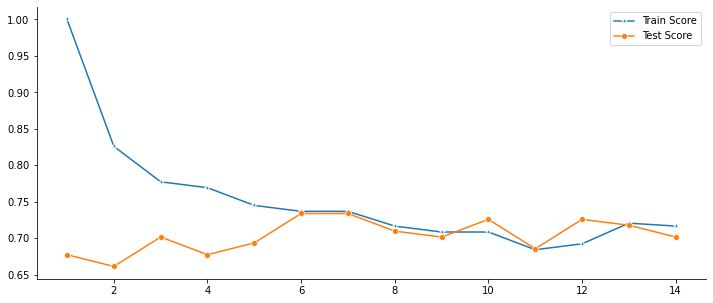

In [67]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')
p.spines['right'].set_visible(False)
p.spines['top'].set_visible(False)

### The best result k=6

In [68]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(6)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.7338709677419355

### Try to visualise 

In [103]:
# """
# Используем понижение размерности с помощью PCA:
# 1) Центрируем массы (вычитаем среднее)
# 2) Нахоим матрицуц ковариации
# 3) Находим сосбтвенные значечния матрицы ковариации
# 4) Транспонируем её, преобразовывая в вектор собственных значений
# 5) Перемножаем вектор на матриицууц - получаем матрицу размерности 1
# """


In [70]:
X_pca = PCA(n_components=2).fit_transform(X)
X_tsne = TSNE(n_components=2).fit_transform(X)
X_lda=LDA(n_components=2).fit_transform(X, y)
print(X_pca.shape, X_tsne.shape, X_lda.shape)
print(y.shape)

(371, 2) (371, 2) (371, 2)
(371,)


Text(0.5, 1.0, 'LDA Scatter Plot')

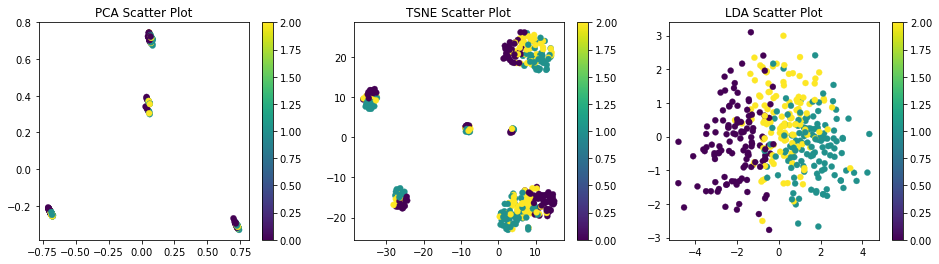

In [85]:
plt.figure(figsize=(16, 4))
#fig, ax = plt.subplots(1, 3, sharex = True, sharey = True, figsize=(15, 4))

plt.subplot(131)
plt.scatter(X_pca[:,0], X_pca[:, 1], c=y, edgecolor='black', linewidth=0.3)
plt.colorbar()
plt.title('PCA Scatter Plot')
plt.subplot(132)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], c=y,  edgecolor='black', linewidth=0.3)
plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.subplot(133)
plt.scatter(X_lda[:,0], X_lda[:, 1], c=y, edgecolor='red', linewidth=0.3)
plt.colorbar()
plt.title('LDA Scatter Plot')

0.717741935483871

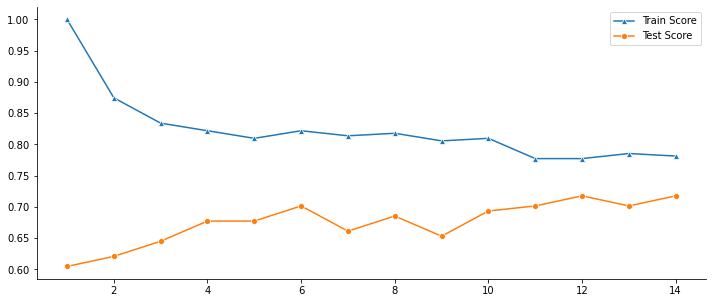

In [73]:
X_train,X_test,y_train,y_test = train_test_split(X_lda, y, test_size=1/3, random_state=42)

test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))
    
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,15),train_scores,marker='^',label='Train Score')
p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')
p.spines['right'].set_visible(False)
p.spines['top'].set_visible(False)

#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(12)

knn.fit(X_train, y_train)
knn.score(X_test, y_test)


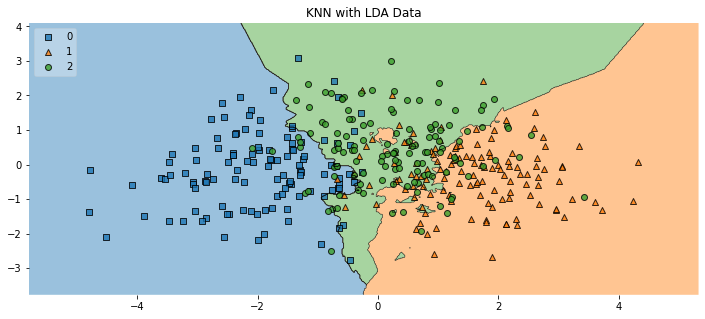

In [74]:
plt.figure(figsize=(12,5))
knn = KNeighborsClassifier(12)

knn.fit(X_train, y_train)
plot_decision_regions(X_lda, y.values, clf=knn, legend=2)

plt.title('KNN with LDA Data')
plt.show()

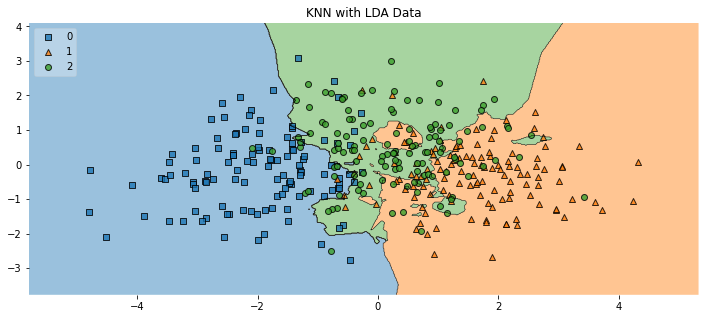

In [75]:
plt.figure(figsize=(12,5))
knn = KNeighborsClassifier(6)

knn.fit(X_train, y_train)
plot_decision_regions(X_lda, y.values, clf=knn, legend=2)

plt.title('KNN with LDA Data')
plt.show()

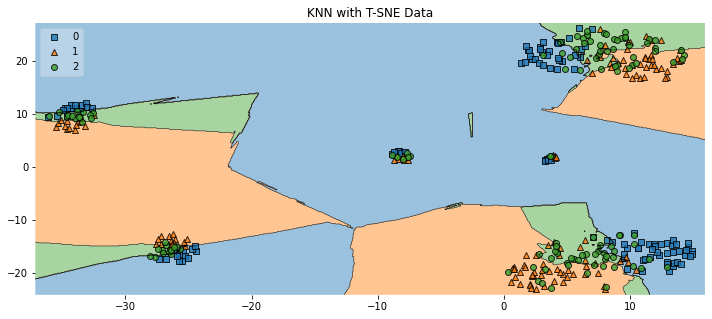

In [76]:
X_train,X_test,y_train,y_test = train_test_split(X_tsne, y, test_size=1/3, random_state=42)
knn = KNeighborsClassifier(12)

knn.fit(X_train, y_train)
knn.score(X_test, y_test)
plt.figure(figsize=(12,5))

plot_decision_regions(X_tsne, y.values, clf=knn, legend=2)

plt.title('KNN with T-SNE Data')
plt.show()

###  $LDA$- best way to convert high-dimensional data

In [88]:
test = pd.read_csv(zip_file.open('test.csv.zip'), compression='zip')
y=train.type.apply(code_target)
X=pd.get_dummies(train.iloc[:,1:6])
lda=LDA(n_components=2)
X_lda=lda.fit_transform(X, y)
test=pd.get_dummies(test.iloc[:,1:6])
pd.get_dummies(train.iloc[:,1:6])
test_lda=lda.transform(test)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)


In [89]:
sample_submission = pd.read_csv(zip_file.open('sample_submission.csv.zip'), compression='zip')
sample_submission['type']=knn.predict(test_lda)
sample_submission['type'] =  sample_submission['type'].apply(reverse_target)
sample_submission.to_csv('LDA_KNN_6or12.csv',index = False)

### Baseline Classifications

In [90]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [91]:
def create_features(dataframe):
    #Create some new variables.
    dataframe['hair_soul'] = dataframe['hair_length'] * dataframe['has_soul']
    dataframe['bone_soul'] = dataframe['bone_length'] * dataframe['has_soul']
    dataframe['hair_bone'] = dataframe['hair_length'] * dataframe['bone_length']
    dataframe['rotting_hair'] = dataframe['rotting_flesh'] * dataframe['hair_length']
    dataframe['rotting_soul'] = dataframe['rotting_flesh'] * dataframe['has_soul']
    
create_features(train)
create_features(test)


In [92]:
train = pd.read_csv(zip_file.open('train.csv.zip'), compression='zip')
test = pd.read_csv(zip_file.open('test.csv.zip'), compression='zip')
sample_submission = pd.read_csv(zip_file.open('sample_submission.csv.zip'), compression='zip')

y=train.type.apply(code_target)

test=pd.get_dummies(test.iloc[:,1:6])
train=pd.get_dummies(train.iloc[:,1:6])


create_features(train)
create_features(test)

def make_answer(X, y, test, clf, name_csv : str):
    X_train,X_test,y_train,y_test = train_test_split(train,y,test_size=1/2,random_state=42, stratify=y)
    clf.fit(X_train, y_train)
    
    print(f'Test accuracy {name_csv} model: {accuracy_score(y_test, clf.predict(X_test))}')
    
    clf.fit(X, y)
    sample_submission = pd.read_csv(zip_file.open('sample_submission.csv.zip'), compression='zip')
    sample_submission['type']=clf.predict(test)
    sample_submission['type']=sample_submission['type'].apply(reverse_target)
    sample_submission.to_csv(f'{name_csv}.csv',index = False)

In [93]:
params = {'colsample_bytree': 0.6522,
          'gamma': 3.6975,
          'learning_rate': 0.0503,
          'max_delta_step': 2.0706,
          'max_depth': 10,
          'min_child_weight': 31.5800,
          'n_estimators': 166,
          'subsample': 0.8639
         }

models=[LogisticRegression(), XGBClassifier(**params), SVC(), RandomForestClassifier(random_state=1), 
        KNeighborsClassifier(), MLPClassifier(solver='lbfgs', random_state=1)]
models_nams=['LogisticRegression', 'XGBClassifier', 'SVC', 'RandomForestClassifier', 'KNeighborsClassifier', 'MLPClassifier']

for i in range(6):
    make_answer(train, y, test, models[i], models_nams[i])

Test accuracy LogisticRegression model: 0.7526881720430108
Test accuracy XGBClassifier model: 0.7365591397849462
Test accuracy SVC model: 0.6774193548387096
Test accuracy RandomForestClassifier model: 0.7365591397849462
Test accuracy KNeighborsClassifier model: 0.6451612903225806
Test accuracy MLPClassifier model: 0.6344086021505376


Result: best position - top 50% without mix model and tune params

1. Test accuracy LogisticRegression model: 0.7526881720430108 Kaggle Test accuracy: 0.73345
2. Test accuracy XGBClassifier model: 0.7365591397849462 Kaggle Test accuracy: 0.73724
3. Test accuracy SVC model: 0.6774193548387096 Kaggle Test accuracy: 0.73345
4. Test accuracy RandomForestClassifier model: 0.7365591397849462 Kaggle Test accuracy: 0.67485
5. Test accuracy KNeighborsClassifier model: 0.6451612903225806 Kaggle Test accuracy: 0.68241
6. Test accuracy MLPClassifier model: 0.6344086021505376 Kaggle Test accuracy: 0.67485

In [102]:
result = pd.DataFrame({'Model' : [], 'Score' : [], 'Kaggle Score': []})

result=result.append({'Model': 'LogisticRegression', 'Score' : 0.7526 ,'Kaggle Score':0.73345 }, ignore_index=True)
result=result.append({'Model': 'XGBClassifier', 'Score' : 0.7365 , 'Kaggle Score':0.73724 }, ignore_index=True)
result=result.append({'Model': 'SVC ', 'Score' : 0.6774 , 'Kaggle Score':0.7334 }, ignore_index=True)
result=result.append({'Model': 'RandomForestClassifier', 'Score' : 0.7365 , 'Kaggle Score':0.67485 }, ignore_index=True)
result=result.append({'Model': 'KNeighborsClassifier', 'Score' : 0.6451 ,'Kaggle Score':0.68241 }, ignore_index=True)
result=result.append({'Model': 'MLPClassifier', 'Score' : 0.6344 , 'Kaggle Score':0.67485 }, ignore_index=True)

result.sort_values(['Kaggle Score', 'Score'], ascending=False)

,Model,Score,Kaggle Score
1,XGBClassifier,0.7365,0.73724
0,LogisticRegression,0.7526,0.73345
2,SVC,0.6774,0.73340
4,KNeighborsClassifier,0.6451,0.68241
3,RandomForestClassifier,0.7365,0.67485
5,MLPClassifier,0.6344,0.67485
